# Vectorized version of Gene Expression Programming
- Here the genes are fully vectorized and tokenized
- The algorithm just relies on three basis functions:
- Dominant inheritance
- Rezessiv inheritance
- Gene Fussion
- The programm mainly relies on numpy arrays for the genetic representation

In [77]:
#Import some packages
from deap.tools import selTournament
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

#Define some helper Functions
def find_indices_with_sum(arr, target_sum, num_indices):
    if arr[0]==-1:
        return [0]
    cum_sum = np.cumsum(arr)
    indices = np.where(cum_sum == target_sum)[0]
    if len(indices) >= num_indices:
        return indices[:num_indices]
    else:
        return []
    
def compile_to_function_string(rek_string, arity_map, **kwargs):
    """
    Using the compile recursive for the expression
    """
    stack = []
    for elem in rek_string[::-1]:
        if arity_map.get(elem, 0) == 2:
            op1 = stack.pop()
            op2 = stack.pop()
            stack.append('(' + op1 + elem + op2 + ')')
        elif arity_map.get(elem, 0) == 1:
            op1 = stack.pop()
            stack.append(elem + '(' + op1 + ')')
        elif arity_map.get(elem, 0) == -1:
            op1 = stack.pop()
            stack.append('(' + op1 + ')'+elem)
        else:
            stack.append(elem)
    return stack[-1]


#Class Toolbox - contains different info of the alg
class Toolbox(object):
    def __init__(self, gene_count, head_len, symbols, gene_connections, 
                 mutation_prob, crossover_prob, fusion_prob):
        self.gene_count = gene_count
        self.head_len = head_len
        self.headsyms = {}
        self.tailsyms = {}
        self.id_to_char = {}
        self.char_to_id = {}
        self.arrity_by_id = {}
        self.symbols = symbols
        self.gene_connections = gene_connections
        self.mutation_prob = mutation_prob
        self.crossover = crossover_prob
        self.fusion_prob = fusion_prob
    
    @property
    def arrity_by_id(self):
        return self._arrity_by_id
    
    @property
    def fusion_prob(self):
        return self._fusion_prob
    
    @fusion_prob.setter
    def fusion_prob(self, fusion_prob):
        self._fusion_prob = fusion_prob
        return self
    
    @property
    def crossover_prob(self):
        return self._crossover_prob
    
    @property
    def mutation_prob(self):
        return self._mutation_prob
    
    @property
    def gene_count(self):
        return self._gene_count
    
    @property
    def head_len(self):
        return self._head_len
    
    @property
    def headsyms(self):
        return self._headsyms
    
    @property
    def tailsyms(self):
        return self._tailsyms
    
    @property
    def symbols(self):
        return self._symbols 
    
    @property
    def gene_connections(self):
        return self._gene_connections
    
    @gene_connections.setter
    def gene_connections(self, value): 
        self._gene_connections = [self.char_to_id[elem] for elem in value]
    
    @symbols.setter
    def symbols(self, value):
        self._symbols = value
        self.char_to_id = {elem:index for index,elem in enumerate(value.keys())}
        self.id_to_char = {index:elem for elem, index in self.char_to_id.items()}
        self.headsyms = [self.char_to_id[key] for key,arity in  value.items()]
        self.tailsyms = [self.char_to_id[key] for key,arity in  value.items() if arity<1]
        self.arrity_by_id = {index:arity for (_,arity), index in zip(value.items(),
                                                                     range(len(value.keys())))}
        return self
    
    @head_len.setter
    def head_len(self, value):
        self._head_len = value
        return self
    
    @gene_count.setter
    def gene_count(self, value):
        self._gene_count = value
        return self
    
    @mutation_prob.setter
    def mutation_prob(self, value):
        self._mutation_prob = value
        return self
    
    @crossover_prob.setter
    def crossover_prob(self, value):
        self._mutation_prob = value
        return self
    
    @headsyms.setter
    def headsyms(self, value):
        self._headsyms = value
        return self
    
    @tailsyms.setter
    def tailsyms(self, value):
        self._tailsyms = value
        return self
    
    @arrity_by_id.setter
    def arrity_by_id(self, value):
        self._arrity_by_id = value
        return self
    
#Repsents the genetic information
class Chromosome(np.ndarray):
    def __new__(cls, genes, toolbox=None):
        obj = np.asarray(genes).view(cls)
        obj.fitness = np.nan
        obj.toolbox = toolbox
        obj.expression = None
        obj.compile_expression()
        return obj
    
    @property
    def fitness(self):
        return self._fitness
    
    @fitness.setter
    def fitness(self, value,):
        self._fitness = value
        return self
     
    #Currently we deal at least with two genes
    def _karva_raw(self):
        gene_len = toolbox.head_len*2+1
        connectionsym = self[:(toolbox.gene_count-1)]
        genes = self[(toolbox.gene_count-1):]
        arity_gene_ = np.vectorize(lambda x: toolbox.arrity_by_id[x])(genes)
        arity_gene_ = np.where(arity_gene_==0, 0, arity_gene_)
        rolled_indices = [connectionsym]
        for i in range(0, len(arity_gene_) - gene_len + 1, gene_len):
            window = arity_gene_[i:i + gene_len]
            window[1:]=window[1:]-1
            indices = find_indices_with_sum(window, 0, 1)
            rolled_indices.append(genes[i:i+indices[0]+1])
        return np.concatenate(rolled_indices)
        
    
    def compile_expression(self):
        if self.expression is None:
            expression = self._karva_raw()
            self.expression = [toolbox.id_to_char[elem] for elem in expression]
            self.expression = compile_to_function_string(self.expression, self.toolbox.symbols)

In [78]:
## Operator for generating
def generate_gene(headsyms, tailsyms, headlen):
    head=np.random.randint(np.min(headsyms),np.max(np.concatenate([headsyms, tailsyms], axis=0))+1,headlen)
    tail=np.random.randint(np.min(tailsyms),np.max(tailsyms)+1,2*headlen+1)
    return np.concatenate([head,tail])

def generate_chromosome(toolbox):
    headsyms = toolbox.headsyms
    tailsyms = toolbox.tailsyms
    head_len = toolbox.head_len
    genecount = toolbox.gene_count
    connectors = toolbox.gene_connections
    gene_connectors = np.random.randint(
        np.min(connectors),np.max(connectors),genecount-1)
    genes = np.concatenate([generate_gene(headsyms, tailsyms, head_len) for _ in range(genecount)],axis=0) 
    return Chromosome(np.concatenate([gene_connectors,genes]), toolbox)
      

def generate_population(number, toolbox):
    return [generate_chromosome(toolbox) for _ in range(number)]

def create_operator_masks(gene_seq_alpha, gene_seq_beta, pb=0.2):
    alpha_operator = np.zeros_like(gene_seq_alpha)
    beta_operator = np.zeros_like(gene_seq_alpha)
    indices_alpha = np.random.randint(0,len(gene_seq_alpha),min(int(pb*len(gene_seq_alpha)),len(gene_seq_alpha)))
    indices_beta = np.random.randint(0,len(gene_seq_alpha),min(int(pb*len(gene_seq_alpha)),len(gene_seq_alpha)))
    alpha_operator[indices_alpha] = 1
    beta_operator[indices_beta] = 1
    return alpha_operator, beta_operator

    
#Operator mixing
def gene_dominant_fusion(gene_seq_alpha, gene_seq_beta, pb=0.2):
    alpha_operator, beta_operator = create_operator_masks(gene_seq_alpha, gene_seq_beta, pb)
    child_1 = np.where(alpha_operator==1,np.maximum(gene_seq_alpha, gene_seq_beta),gene_seq_alpha) 
    child_2 = np.where(beta_operator==1,np.maximum(gene_seq_alpha, gene_seq_beta), gene_seq_beta)
    return Chromosome(child_1, gene_seq_alpha.toolbox), Chromosome(child_2, gene_seq_alpha.toolbox)

def gen_rezessiv(gene_seq_alpha, gene_seq_beta, pb=0.2):
    alpha_operator, beta_operator = create_operator_masks(gene_seq_alpha, gene_seq_beta, pb)
    child_1 = np.where(alpha_operator==1,np.minimum(gene_seq_alpha, gene_seq_beta),gene_seq_alpha) 
    child_2 = np.where(beta_operator==1,np.minimum(gene_seq_alpha, gene_seq_beta), gene_seq_beta)
    return Chromosome(child_1, gene_seq_alpha.toolbox), Chromosome(child_2, gene_seq_alpha.toolbox)

def gene_fussion(gene_seq_alpha, gene_seq_beta, pb=0.2):
    alpha_operator, beta_operator = create_operator_masks(gene_seq_alpha, gene_seq_beta, pb)
    child_1 = np.where(alpha_operator==1,(gene_seq_alpha+gene_seq_beta)//2,gene_seq_alpha) 
    child_2 = np.where(beta_operator==1,(gene_seq_alpha+gene_seq_beta)//2, gene_seq_beta)
    return Chromosome(child_1, gene_seq_alpha.toolbox), Chromosome(child_2, gene_seq_alpha.toolbox)

# Test the implementation

In [79]:
#Create a Dataset with 100 points
x_data = np.linspace(-1,1,100)
y_data = np.vectorize(lambda x: x**3+x**2+x+4)(x_data)
data_set = {'x_0':x_data, 'y':y_data}

#Define the symbols 

symbols = {
    '+':2,
    '*':2,
    '-':2,
    '//':2,
    'x_0':0,
    '2':0,
}

toolbox = Toolbox(2,10,symbols,{"+":2,'-':2},0.1,0.1,0.1)
population = generate_population(1000,toolbox)

In [80]:
#Define the operators
epochs = 200
for epoch in tqdm(range(epochs)):
    fits = []
    for elem in population:
        try:
            y_pred = eval(elem.expression,data_set)
            elem.fitness = mean_absolute_error(data_set['y'], y_pred)
        except:
            elem.fitness = 10e6
        fits.append(elem.fitness)
    population = sorted(population, key=lambda x: x.fitness)
    if epoch<epochs-2:
        tournie = selTournament(population[:len(population)//2], len(population)//2, 3, fit_attr='fitness')
        next_gen = []
        for index in range(0,len(tournie),2):
                t1 = tournie[index]
                t2 = tournie[index+1]
                t1,t2 = gene_dominant_fusion(t1,t2)
                t1,t2 = gen_rezessiv(t1,t2)
                t1,t2 = gene_fussion(t1,t2)
                next_gen.append(t1)
                next_gen.append(t2)
        population = population[:len(population)//2] + next_gen

100%|█████████████████████████████████████████| 200/200 [01:10<00:00,  2.83it/s]


In [81]:
#Retrieve the best expression
expression = population[np.argmin(population)].expression
y_pred = eval(expression, data_set)

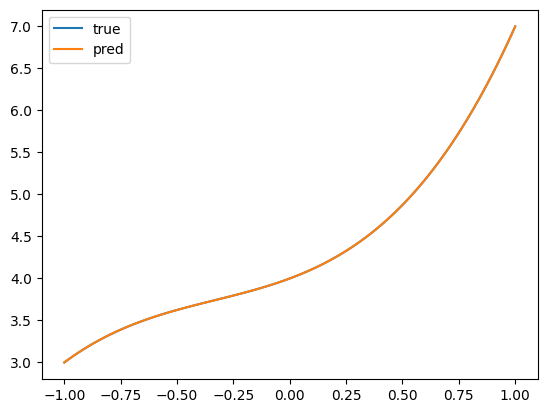

In [82]:
#Have a look on how close we are
plt.plot(x_data, y_data, label='true')
plt.plot(x_data, y_pred, label='pred')
plt.legend()

In [83]:
#Print out the expression
import sympy as sp
sp.simplify(expression)

x_0**2*(x_0 + 1) + x_0 + 4